In [163]:
# import packages

import networkx as nx
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
torch.set_printoptions(sci_mode=False)
from sklearn.neighbors import DistanceMetric
from torchmetrics import R2Score
from math import radians
from numpy import inf
import time

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# mta ridership - aggregated on 1d intervals

mta = pd.read_csv('/Users/devashishkhulbe/Desktop/research/GNN-traffic/subway_2021_ridership.csv')
mta = mta[mta['flag'] == True]
# aggregate on daily 

mta['DATE_time'] = pd.to_datetime(mta['DATE_time'])
mta['DATE'] = mta['DATE_time'].dt.date
mta_rider = mta.groupby(by=['DATE', 'STATION'], as_index=False).sum()[['DATE', 'STATION', 'ridership']]

daily_rider = pd.pivot(data=mta_rider, index='DATE', columns=['STATION'], values='ridership')
daily_rider.index = pd.DatetimeIndex(daily_rider.index)
daily_rider.head()

STATION,1 AV,103 ST,103 ST-CORONA,104 ST,110 ST,111 ST,116 ST,121 ST,125 ST,135 ST,...,WAKEFIELD/241,WALL ST,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,WORLD TRADE CTR,YORK ST,ZEREGA AV
DATE,,,,,,,,,,,,,,,,,,,,,
2020-12-26,191.0,317.0,703.0,20.0,239.0,70.0,84.0,216.0,782.0,1.0,...,267.0,53.0,35.0,299.0,224.0,800.0,362.0,71.0,7309.0,44.0
2020-12-27,159.0,366.0,649.0,19.0,229.0,87.0,65.0,213.0,822.0,0.0,...,315.0,46.0,20.0,253.0,188.0,696.0,349.0,60.0,447.0,47.0
2020-12-28,310.0,662.0,953.0,36.0,399.0,145.0,139.0,407.0,1226.0,536.0,...,495.0,218.0,55.0,478.0,542.0,1079.0,663.0,173.0,867.0,100.0
2020-12-29,390.0,678.0,1002.0,54.0,368.0,157.0,157.0,420.0,1187.0,57.0,...,478.0,227.0,48.0,461.0,573.0,1430.0,686.0,178.0,896.0,123.0
2020-12-30,402.0,680.0,1169.0,50.0,407.0,143.0,177.0,445.0,1116.0,NaN,...,484.0,238.0,52.0,454.0,538.0,1195.0,696.0,173.0,894.0,121.0


In [3]:
daily_rider.fillna(0, inplace=True)

In [4]:
st_nodes = pd.read_csv('/Users/devashishkhulbe/Desktop/research/GNN-traffic/subway_locations_connections.csv')
st_nodes = st_nodes[st_nodes.origin_name.isin(daily_rider.columns)]
st_nodes.head()

,origin_name,origin_id,origin_lat,origin_long,dest_name,dest_id,dest_lat,dest_long
0,1 AV,L06,40.730953,-73.981628,"['3 Av', 'Bedford Av']","['L05', 'L08']","[40.732849, 40.717304]","[-73.986122, -73.956872]"
1,103 ST,119,40.799446,-73.968379,"['96 St', 'Cathedral Pkwy']","['120', '118']","[40.793919, 40.803967]","[-73.972323, -73.966847]"
3,104 ST,A63,40.681711,-73.837683,"['111 St', 'Rockaway Blvd']","['A64', 'A61']","[40.684331, 40.680429]","[-73.832163, -73.843853]"
4,110 ST,623,40.795020,-73.944250,"['116 St', '103 St']","['622', '624']","[40.798629, 40.7906]","[-73.941617, -73.947478]"
5,111 ST,705,40.751730,-73.855334,"['103 St - Corona Plaza', 'Mets - Willets Point']","['706', '702']","[40.749865, 40.754622]","[-73.8627, -73.845625]"


In [5]:
# get pairwise distance matrix for stations

st_nodes['lat'] = np.radians(st_nodes['origin_lat'])
st_nodes['lon'] = np.radians(st_nodes['origin_long'])

dist = DistanceMetric.get_metric('haversine')

dist_mat = pd.DataFrame(dist.pairwise(st_nodes[['lat','lon']].to_numpy())*6373, 
            columns=st_nodes.origin_name.unique(), index=st_nodes.origin_name.unique())
dist_mat.head()

,1 AV,103 ST,104 ST,110 ST,111 ST,116 ST,121 ST,125 ST,135 ST,14 ST,...,UTICA AV,VAN SICLEN AV,WALL ST,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,YORK ST,ZEREGA AV
1 AV,0.000000,7.699793,13.315928,7.790916,10.891409,8.360095,13.363806,9.614835,9.881507,1.742099,...,7.165696,10.657503,3.545233,13.322841,8.050454,8.679101,9.476755,19.302260,3.315759,16.318356
103 ST,7.699793,0.000000,17.111840,2.090550,10.901203,1.606393,16.139479,1.982606,2.847249,7.359564,...,13.728424,16.323663,10.858988,7.538986,13.451989,15.956699,11.145279,12.232963,11.015300,11.014042
104 ST,13.315928,17.111840,0.000000,15.476050,7.929091,16.380034,2.234051,18.031898,17.109241,15.057272,...,7.852937,4.722588,14.723681,16.620009,5.652151,9.893384,6.305171,22.988831,12.761335,17.233845
110 ST,7.790916,2.090550,15.476050,0.000000,8.904054,0.908104,14.353675,2.577603,2.156610,7.917566,...,12.914771,15.135674,11.229567,6.007913,12.294897,15.398820,9.347276,11.526924,11.012307,9.393876
111 ST,10.891409,10.901203,7.929091,8.904054,0.000000,9.719267,6.138084,11.213726,10.005169,12.305575,...,10.256406,10.017515,13.890225,8.718144,8.118810,13.260082,2.379598,15.068429,12.411960,9.453478


In [6]:
# keep only the stations we have data for

daily_rider = daily_rider.iloc[:, daily_rider.columns.isin(st_nodes.origin_name)]

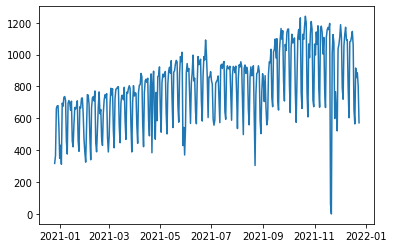

In [7]:
plt.plot(daily_rider['103 ST'])

In [705]:
# get lag features and labels

features = np.load('features.npy')
labels = np.load('labels.npy')

# features = 7 day lagged ridership for stations
features = torch.FloatTensor(features[:, :, :])
labels = torch.FloatTensor(labels)

In [499]:
features[0]

tensor([[130., 343., 402.,  ...,   0.,   1.,   0.],
        [349., 554., 680.,  ...,   0.,   1.,   0.],
        [ 40.,  74.,  50.,  ...,   0.,   1.,   0.],
        ...,
        [266., 570., 696.,  ...,   0.,   1.,   0.],
        [379., 732., 894.,  ...,   0.,   1.,   0.],
        [ 37.,  75., 121.,  ...,   0.,   1.,   0.]])

T_a = $\sum K(l, tw(t))(\sum w(a, b, l)s(b, a)T(b, t-l))/\sum w(a, b)$

In [706]:
class custom_model(nn.Module):
    def __init__(self,in_dim, out_dim):
        super(custom_model, self).__init__()

        # weight1 = parameter 'K(l, wt(l))'
        weight1_eye = torch.FloatTensor(torch.eye(out_dim, in_dim))
        weight1_eye = weight1_eye.reshape((1, out_dim, in_dim))
        self.weight1 = Parameter(weight1_eye)
        
        # weight2 = parameter 'w(a, b, l)'
        weight2 = torch.FloatTensor(torch.eye(out_dim, out_dim))
        self.weight2 = Parameter(weight2)
        
        self.bias = torch.nn.Parameter(torch.ones(in_dim))

    def forward(self, input_features, adj, weight2=True):
    
        # weight2 = True if optimizing both K and w, otherise optimizing just K
        if weight2:
            h = torch.mul(adj.repeat(input_features.shape[0], 1, 1), 
                          self.weight2.repeat(input_features.shape[0], 1, 1))
            j = torch.bmm(h, input_features)
    #         k = torch.div(j, self.weight2.repeat(input_features.shape[0], 1, 1))
            y = torch.mul(j, self.weight1.repeat(input_features.shape[0], 1, 1)) 
            res = torch.div(y.sum(dim=2), self.weight2.repeat(input_features.shape[0], 1, 1).sum(dim=2))
            return res
        
        else:
            y = torch.mul(input_features, self.weight1.repeat(input_features.shape[0], 1, 1))
            return y.sum(dim=2)

In [707]:
cuda = torch.cuda.is_available()
weight_decay = 10e-3
epochs = 7000
seed = 165
# hidden = 10
lr = 0.01

# initialize w(a, b) matrix as exp(-dist(a, b))
# adj_new = torch.FloatTensor(dist_mat.values)
adj = np.exp(-dist_mat.values)
n = len(adj)
d = adj.ravel()[::n+1]
values = d.copy()
adj[:,:] = 0
d[:] = values
adj = np.expand_dims(adj, axis=0)
adj_new = torch.FloatTensor(adj)
# adj_new = adj.repeat(357, 1, 1)

def get_r2(label, out, ndays):
    
    r = []
    for i in range(0, ndays):
        r.append(r2score(out[:, i], label[:, 0, i]).item())
    r = np.nan_to_num(r, posinf=0, neginf=0)
    return np.nanmean(r)

In [708]:
# first 200 days as train, rest 157 days as test set

train_features, test_features = features[:200, :, :], features[200:, :, :]
train_labels, test_labels = labels[:200, :, :], labels[200:, :, :]

optimize_weight2 = False

model = custom_model(features.shape[-1], 238)

model = model.float()

# Train model
t_total = time.time()

    # Using adam optimizers for backpropogation
optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)

criterion = nn.MSELoss()

r2score = R2Score()

for epoch in range(epochs):
  

    t = time.time()
    model.train()
        
        # Pytorch accumulates gradient after every operation on tensors (defined by the model architecture)
        # with require_grad = True. With each new epoch, we need to reset this gradient to 0 to calculate gradient
        # for this epoch.
    optimizer.zero_grad()

        # get the output from forward propogation of our model
    output = model(train_features, adj_new, weight2=optimize_weight2)
    
    # Calculate test accuracy
    with torch.no_grad():
        test_output = model(test_features, adj_new, optimize_weight2)
#         test_accuracy = r2score(test_labels.reshape(-1), test_output.reshape(-1))
        test_accuracy = get_r2(test_labels, test_output, 157)
            
#     accuracy = r2score(train_labels.reshape(-1), output.reshape(-1))
    accuracy = get_r2(train_labels, output, 200)
    
    loss = criterion(output.reshape(-1), train_labels.reshape(-1))
        
        # Calculate the gradients 
    loss.backward(retain_graph=True)

        # Update the weights
    optimizer.step()
    
    if epoch == 0:
        best_loss = loss
        best_output = output
        best_acc = accuracy
    else:
        if loss < best_loss:
            best_loss = loss
            best_output = output
            best_acc = accuracy
            best_test_acc = test_accuracy
            best_test_output = test_output

        if epoch % 500 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'Accuracy: {:.4f}'.format(best_acc),
                  'Loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t),
                  'test accuracy: {:.4f}'. format(best_test_acc))
            
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0501 Accuracy: 0.5736 Loss: 19919.01367188 time: 0.0931s test accuracy: 0.4847
Epoch: 1001 Accuracy: 0.5809 Loss: 19665.43945312 time: 0.0771s test accuracy: 0.4888
Epoch: 1501 Accuracy: 0.5825 Loss: 19582.02929688 time: 0.0802s test accuracy: 0.4900
Epoch: 2001 Accuracy: 0.5833 Loss: 19528.32812500 time: 0.0923s test accuracy: 0.4908
Epoch: 2501 Accuracy: 0.5836 Loss: 19492.09960938 time: 0.0764s test accuracy: 0.4913
Epoch: 3001 Accuracy: 0.5838 Loss: 19467.64453125 time: 0.0908s test accuracy: 0.4916
Epoch: 3501 Accuracy: 0.5839 Loss: 19451.06640625 time: 0.1031s test accuracy: 0.4918
Epoch: 4001 Accuracy: 0.5839 Loss: 19439.67187500 time: 0.1072s test accuracy: 0.4920
Epoch: 4501 Accuracy: 0.5839 Loss: 19431.63085938 time: 0.1093s test accuracy: 0.4921
Epoch: 5001 Accuracy: 0.5840 Loss: 19425.81250000 time: 0.0759s test accuracy: 0.4922
Epoch: 5501 Accuracy: 0.5840 Loss: 19421.51562500 time: 0.0762s test accuracy: 0.4922
Epoch: 6001 Accuracy: 0.5840 Loss: 19418.30859375 time

In [711]:
# optimized K(l, tw(l))

model.weight1.data

tensor([[[  0.4132,  -0.1431,   0.0911,  ...,   2.9793,  -3.4230,  -3.1886],
         [  0.3515,  -0.0740,   0.0660,  ...,   3.0329,  -2.2571,  -8.4799],
         [  0.5142,  -0.2226,   0.0777,  ...,   1.9898,  -3.6870,  -3.0854],
         ...,
         [  0.2905,  -0.1174,   0.0630,  ...,   3.4181,  -3.0296,  -5.2098],
         [  0.7131,  -0.3356,   0.1410,  ...,  17.7112, -16.3728, -15.5318],
         [  0.2745,  -0.0872,   0.0418,  ...,   0.7549,  -0.7793,  -1.8131]]])